In [13]:
import numpy as np
from ABHA import ABHA
import math
import matplotlib.pyplot as plt
import random

In [14]:

#пчела
class Bee:
    STATE_NOVICE = 0
    STATE_EXPERIENCED = 1
    STATE_SEARCH = 2
    STATE_SOURCE = 3

    def __init__(self, bounds, init_step_size):
        self.bounds = bounds
        self.position = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds])
        self.best_position = self.position.copy()
        self.direction = np.random.uniform(-1, 1, 2)
        self.cost = -np.inf
        self.prev_cost = -np.inf
        self.best_cost = -np.inf
        self.step_size = init_step_size
        self.state = self.STATE_NOVICE


In [19]:
class ABHA:
    def __init__(self,
                 objective_func,
                 bounds,
                 pop_size=20,
                 max_iter=100,
                 random_search_prob=0.1,
                 step_size_reduction=0.98,
                 init_step_size=1.0):
        
        assert len(bounds) == 2, "Визуализация поддерживается только для 2D!"
        self.func = objective_func
        self.bounds = bounds
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.random_search_prob = random_search_prob
        self.step_size_reduction = step_size_reduction
        self.init_step_size = init_step_size

        self.bees = [Bee(bounds, init_step_size) for _ in range(pop_size)]
        self.global_best_position = None
        self.global_best_cost = -np.inf
        self.avg_cost = 0.0
        self.history = []  

    def _clip(self, x):
        return np.clip(x, [b[0] for b in self.bounds], [b[1] for b in self.bounds])

    def _random_position(self):
        return np.random.uniform([b[0] for b in self.bounds], [b[1] for b in self.bounds])

    def _follow_dance(self, source_pos, step):
        noise = np.random.uniform(-step, step, 2)
        return self._clip(source_pos + noise)

    def _local_search(self, pos, step):
        noise = np.random.uniform(-step, step, 2)
        return self._clip(pos + noise)

    def _move_direction(self, bee):
        bee.position = self._clip(bee.position + bee.direction * bee.step_size)
        if random.random() < 0.1:
            bee.direction = np.random.uniform(-1, 1, 2)

    def _act(self, bee):
        if bee.state == Bee.STATE_NOVICE:
            if hasattr(self, 'best_dancer') and random.random() < 0.5:
                bee.position = self._follow_dance(self.best_dancer.position, bee.step_size)
            else:
                bee.position = self._random_position()
        elif bee.state == Bee.STATE_EXPERIENCED:
            r = random.random()
            if r < 0.5 and hasattr(self, 'best_dancer'):
                bee.position = self._follow_dance(self.best_dancer.position, bee.step_size)
            elif r < 0.8:
                bee.position = self._random_position()
            else:
                bee.position = self._local_search(bee.position, bee.step_size)
        elif bee.state == Bee.STATE_SEARCH:
            self._move_direction(bee)
        elif bee.state == Bee.STATE_SOURCE:
            bee.position = self._local_search(bee.position, bee.step_size * 0.5)

    def _update_state(self, bee):
        if bee.cost > self.avg_cost:
            if bee.state == Bee.STATE_NOVICE:
                bee.state = Bee.STATE_EXPERIENCED
            elif bee.state == Bee.STATE_EXPERIENCED:
                bee.state = Bee.STATE_SOURCE
            elif bee.state == Bee.STATE_SEARCH:
                bee.state = Bee.STATE_SOURCE
            elif bee.state == Bee.STATE_SOURCE:
                bee.state = Bee.STATE_EXPERIENCED
        else:
            if bee.state == Bee.STATE_NOVICE:
                bee.state = Bee.STATE_SEARCH
            elif bee.state == Bee.STATE_EXPERIENCED:
                bee.state = Bee.STATE_SEARCH
            elif bee.state == Bee.STATE_SEARCH:
                bee.state = Bee.STATE_NOVICE
            elif bee.state == Bee.STATE_SOURCE:
                bee.state = Bee.STATE_SEARCH

    #рисуем
    def _plot_iteration(self, iteration):
        plt.clf()
        
       #фон
        plt.gca().set_facecolor('white')
        plt.grid(True, linestyle='--', alpha=0.5)

        
        colors = ['gray', 'blue', 'orange', 'red']
        labels = ['Novice', 'Experienced', 'Search', 'Source']
        for state in range(4):
            xs = [b.position[0] for b in self.bees if b.state == state]
            ys = [b.position[1] for b in self.bees if b.state == state]
            if xs:
                plt.scatter(xs, ys, c=colors[state], label=labels[state], s=50)

        # Глобальный лучший
        if self.global_best_position is not None:
            plt.scatter(self.global_best_position[0], self.global_best_position[1],
                        c='gold', marker='v', s=200, edgecolors='black', label='Global Best')

        plt.xlim(self.bounds[0])
        plt.ylim(self.bounds[1])
        plt.title(f'ABHA Optimization — Iteration {iteration}')
        plt.legend()
        plt.pause(0.1) 

    def optimize(self, visualize=True):
        costs = []
        for bee in self.bees:
            bee.cost = self.func(bee.position)
            bee.best_cost = bee.cost
            bee.best_position = bee.position.copy()
            costs.append(bee.cost)

        self.global_best_cost = max(costs)
        self.global_best_position = self.bees[np.argmax(costs)].position.copy()

        if visualize:
            plt.ion()
            fig = plt.figure(figsize=(8, 6))

        for it in range(self.max_iter):
            for bee in self.bees:
                self._act(bee)
                bee.cost = self.func(bee.position)

            costs = [b.cost for b in self.bees]
            if max(costs) > self.global_best_cost:
                idx = np.argmax(costs)
                self.global_best_cost = costs[idx]
                self.global_best_position = self.bees[idx].position.copy()

            self.avg_cost = np.mean(costs)
            best_idx = np.argmax(costs)
            self.best_dancer = self.bees[best_idx]

            for bee in self.bees:
                self._update_state(bee)
                if bee.cost > bee.best_cost:
                    bee.best_cost = bee.cost
                    bee.best_position = bee.position.copy()
                bee.step_size *= self.step_size_reduction

            if visualize:
                self._plot_iteration(it + 1)

        if visualize:
            plt.ioff()
            plt.show()

        return self.global_best_position, self.global_best_cost





In [20]:
def rastrigin_max(x):
    A = 10
    return -(A * 2 + np.sum(x**2 - A * np.cos(2 * np.pi * x)))


In [23]:
dim = 5
bounds = [(-5, 5) for _ in range(dim)]

bounds = [(-5, 5), (-5, 5)]

# Запуск с визуализацией
abha_vis = ABHA(
    objective_func=rastrigin_max,
    bounds=bounds,
    pop_size=30,
    max_iter=120
)

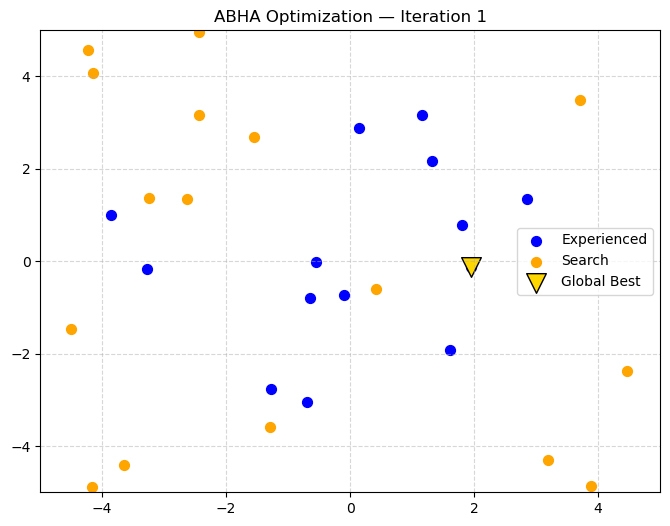

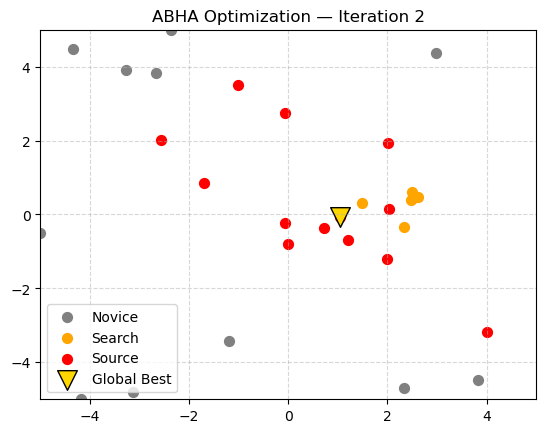

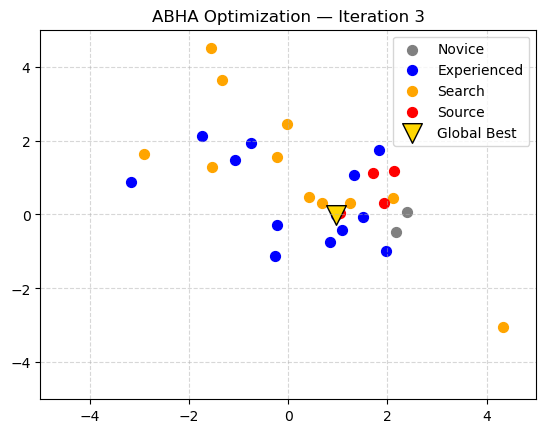

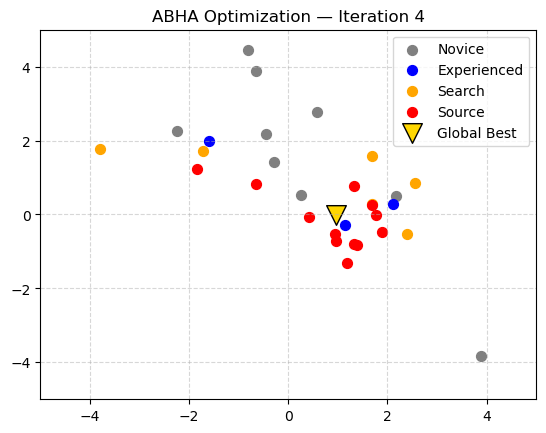

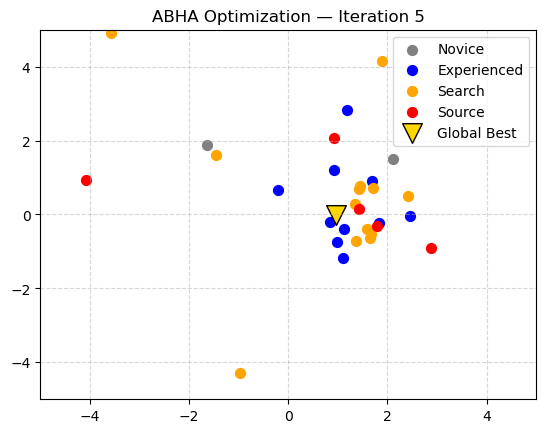

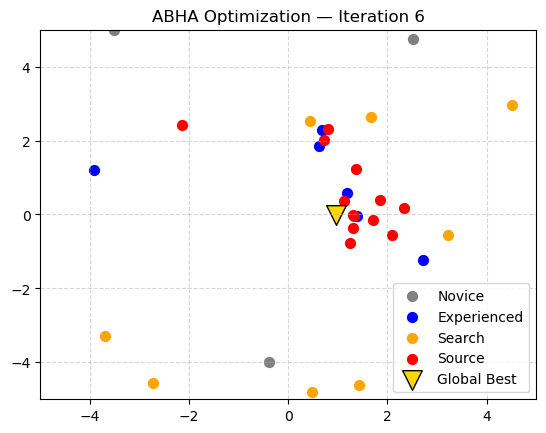

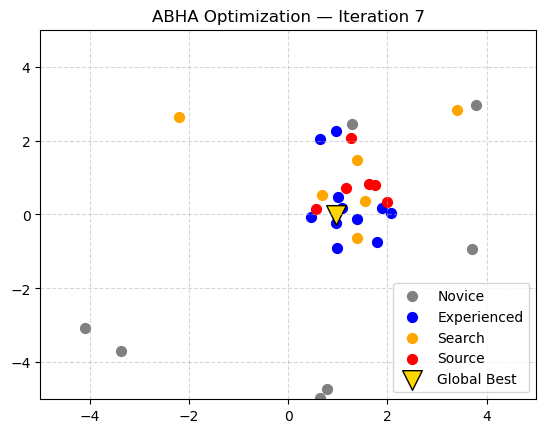

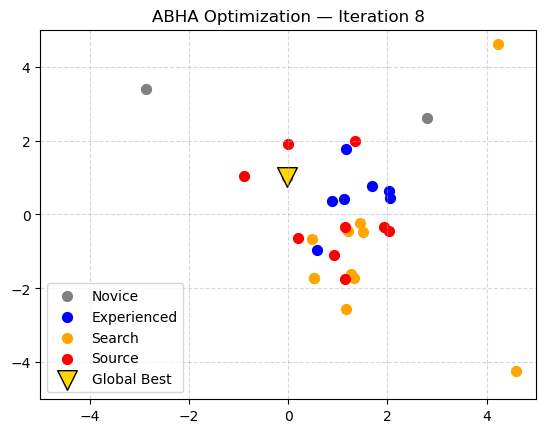

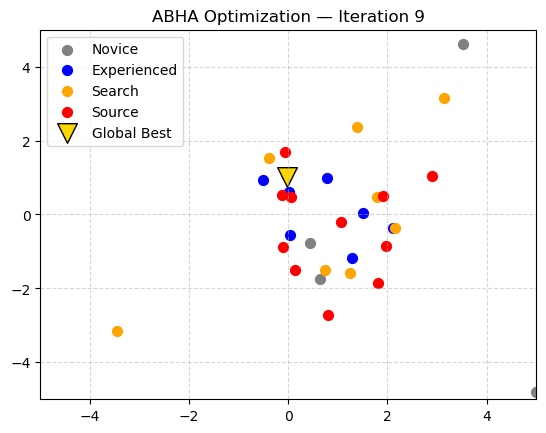

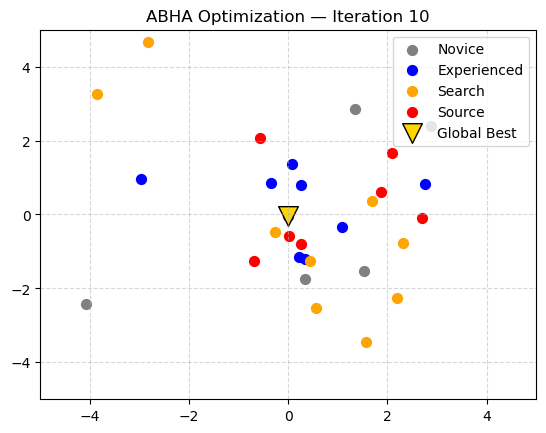

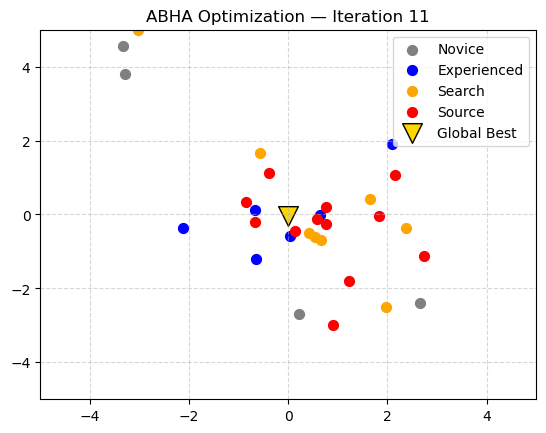

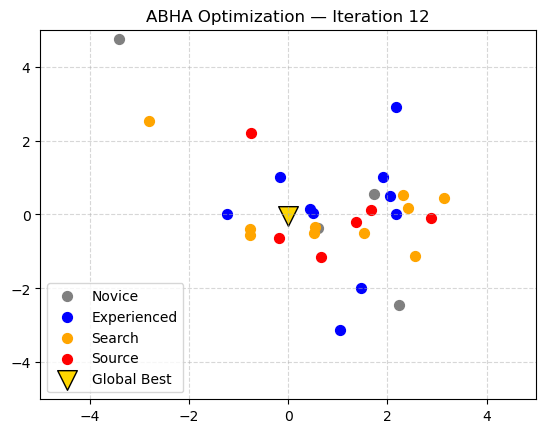

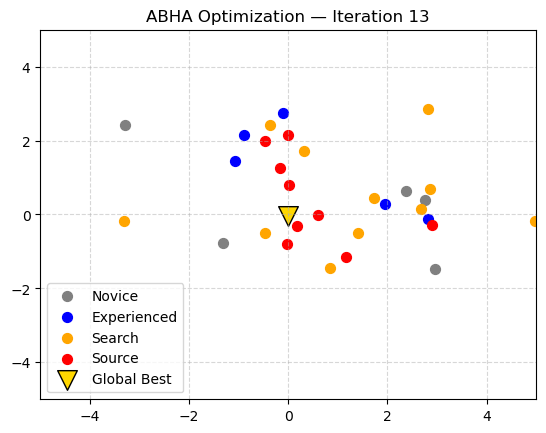

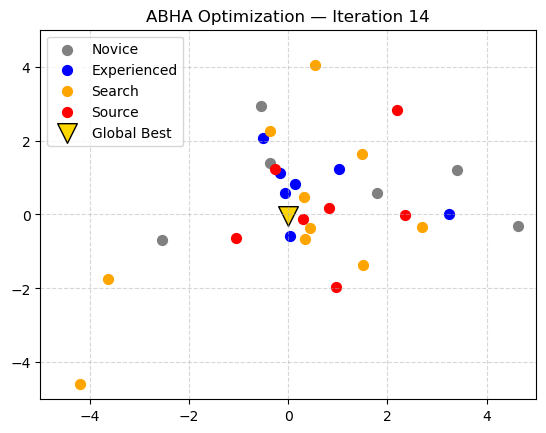

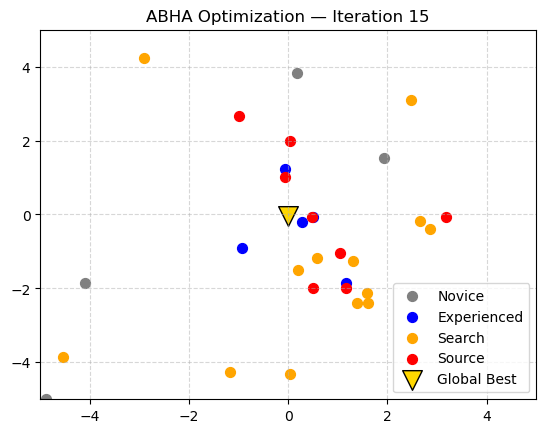

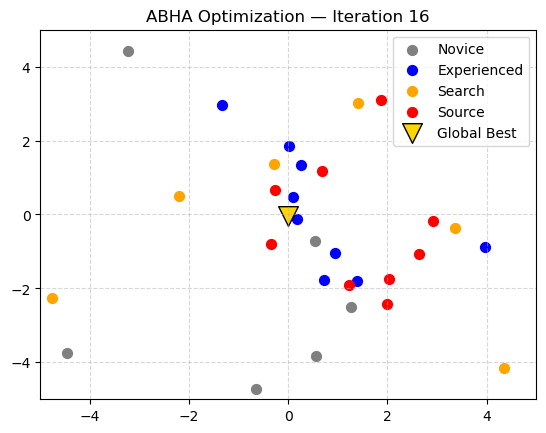

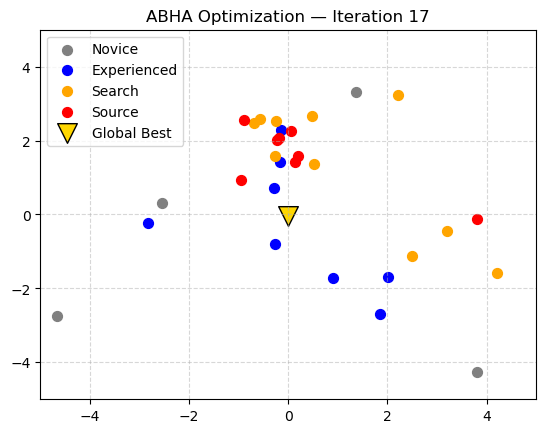

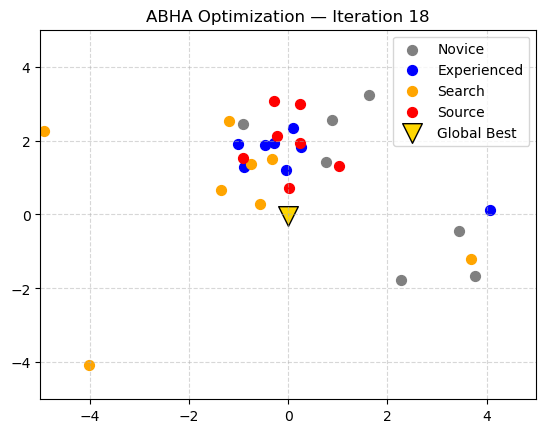

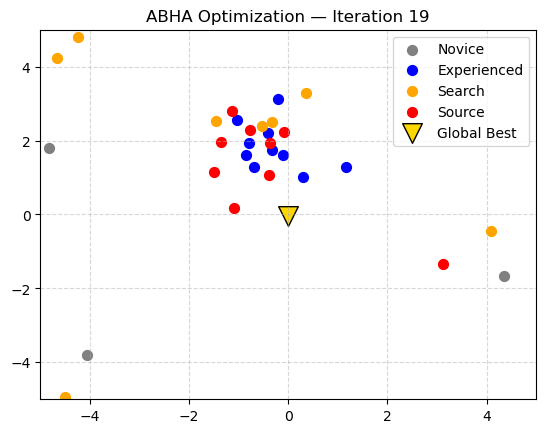

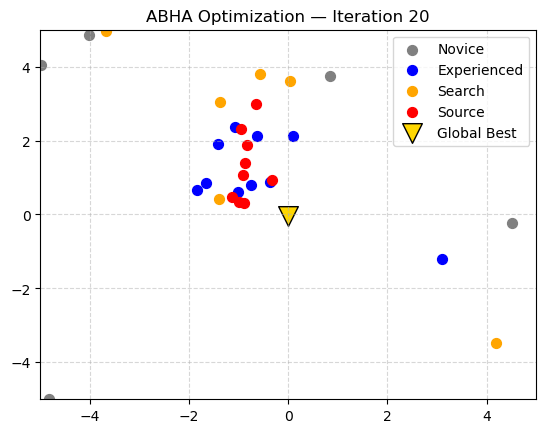

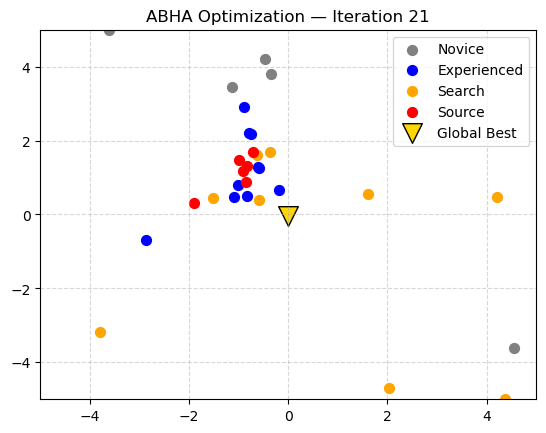

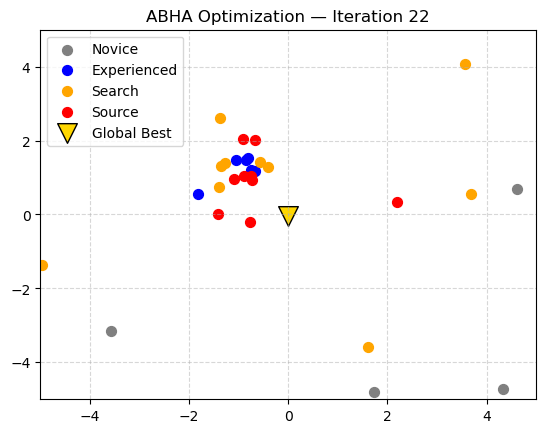

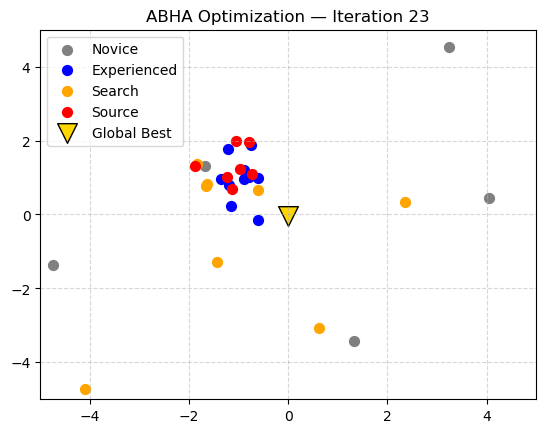

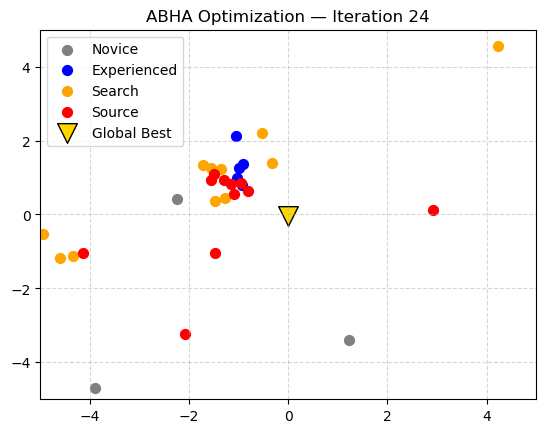

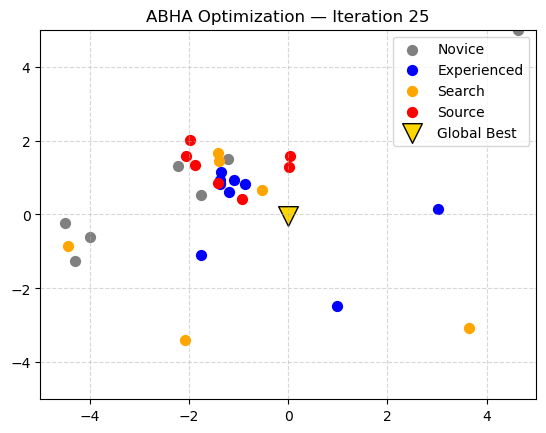

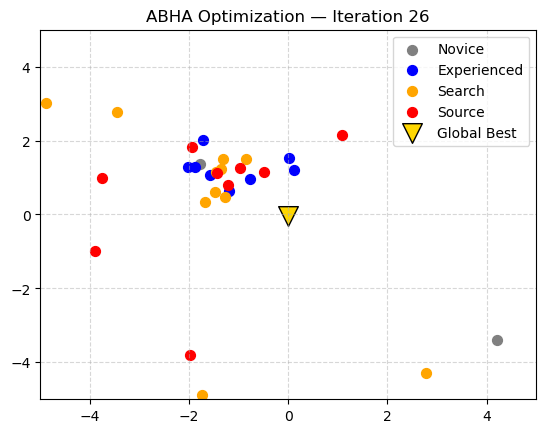

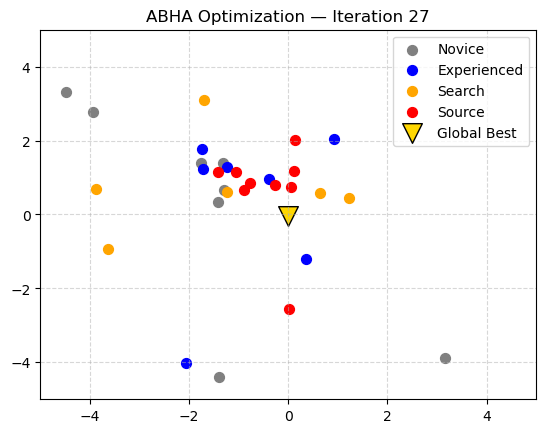

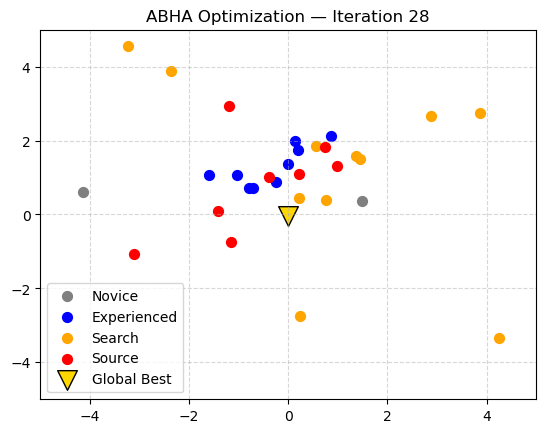

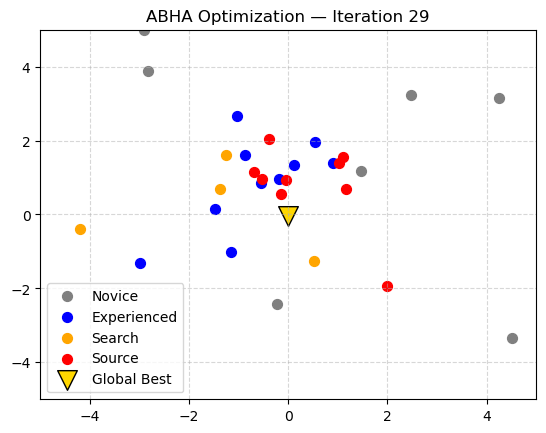

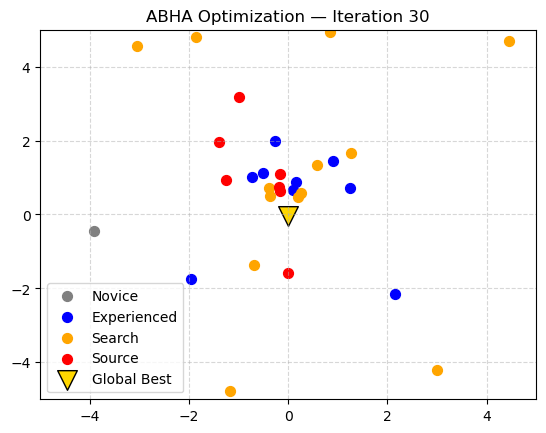

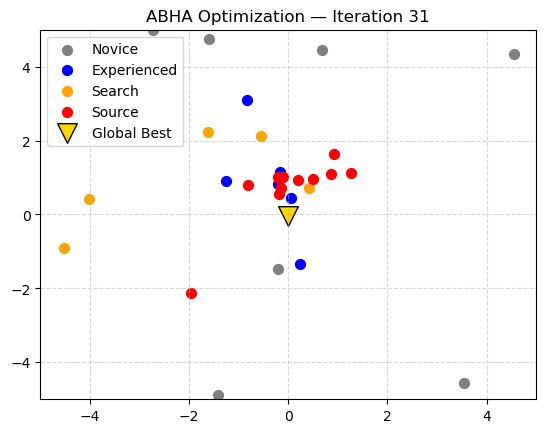

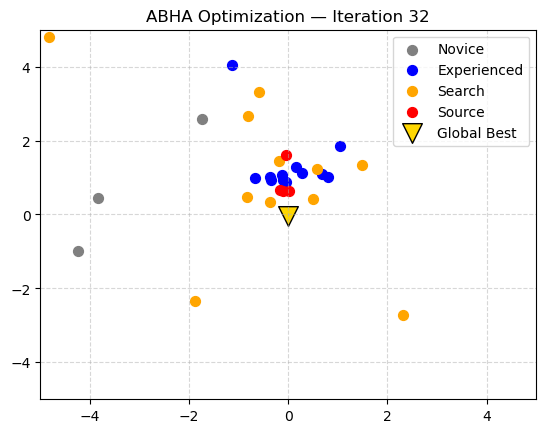

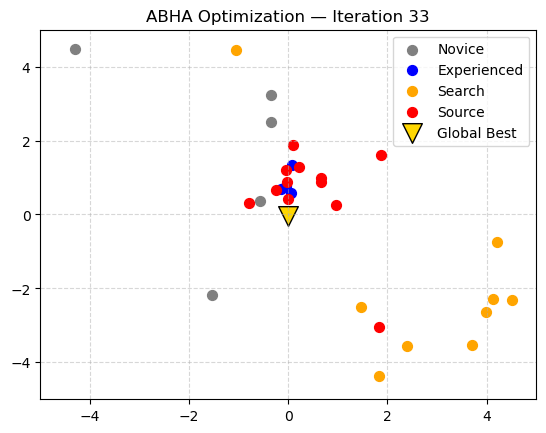

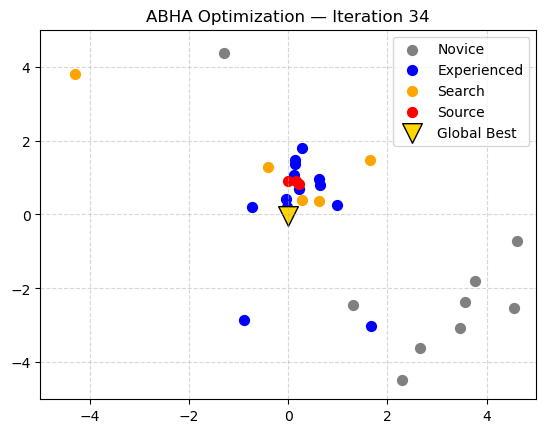

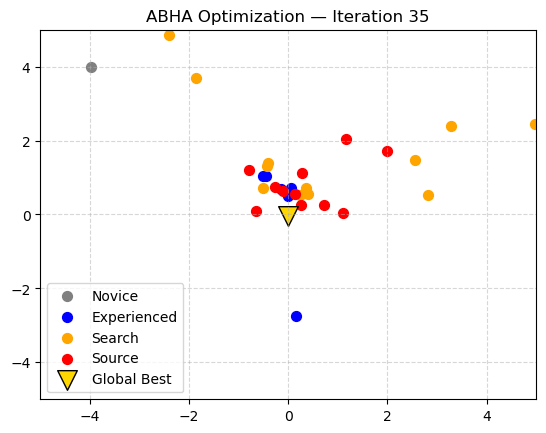

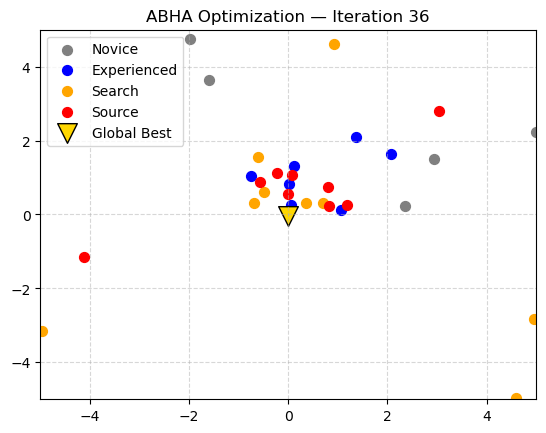

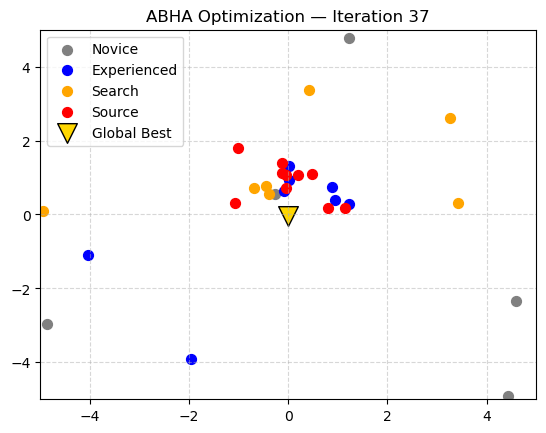

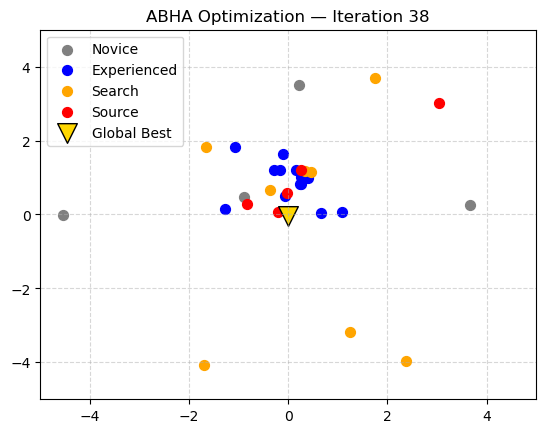

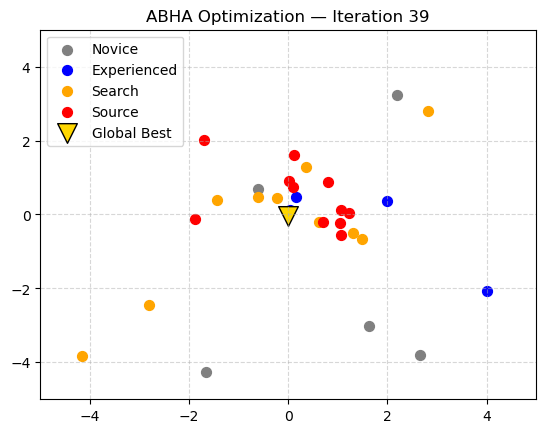

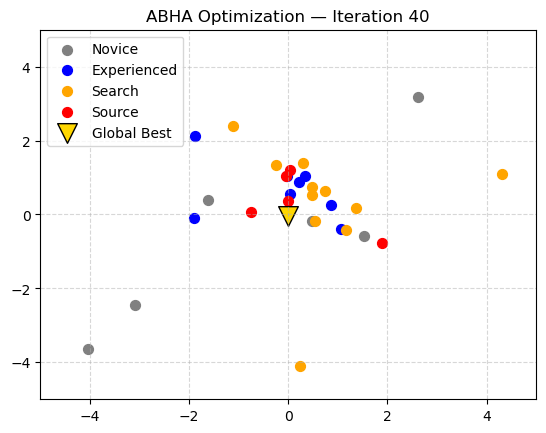

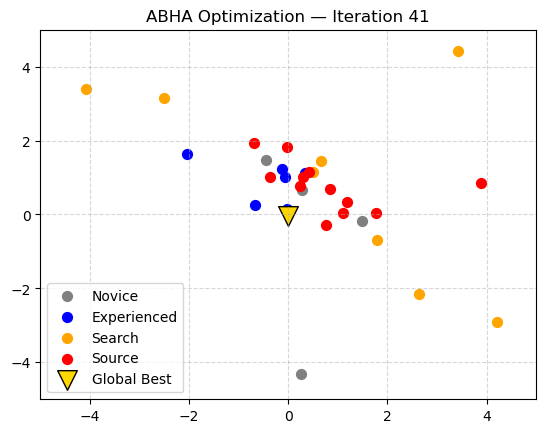

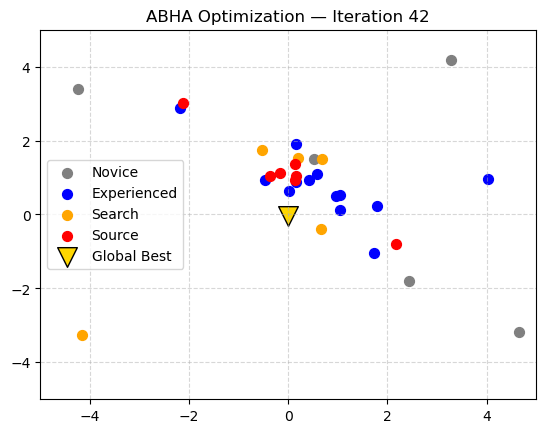

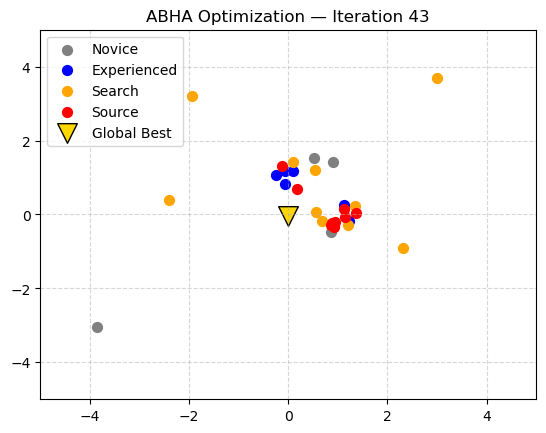

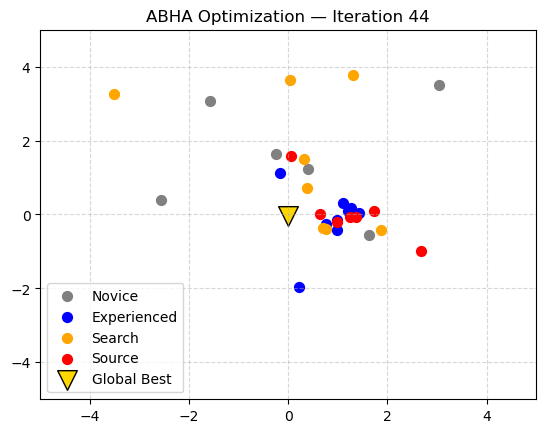

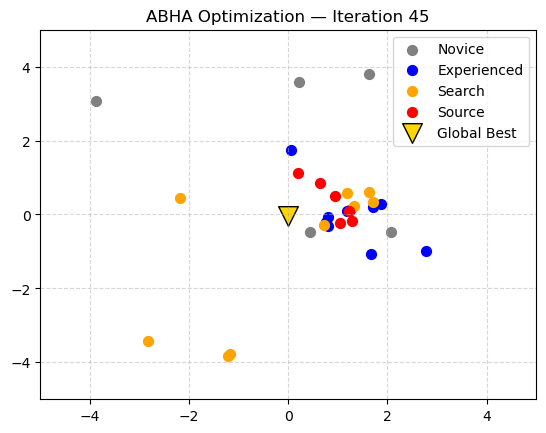

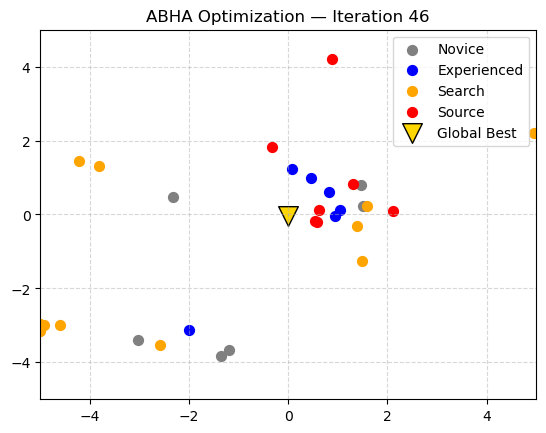

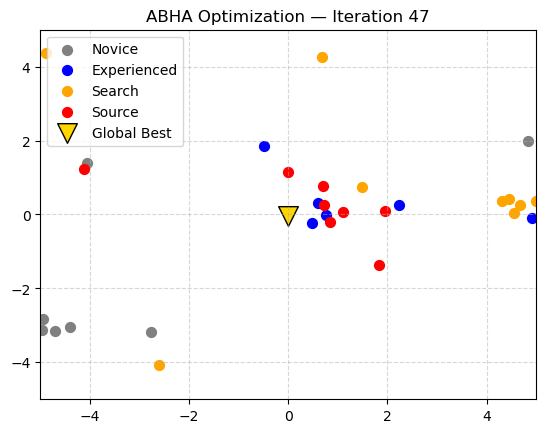

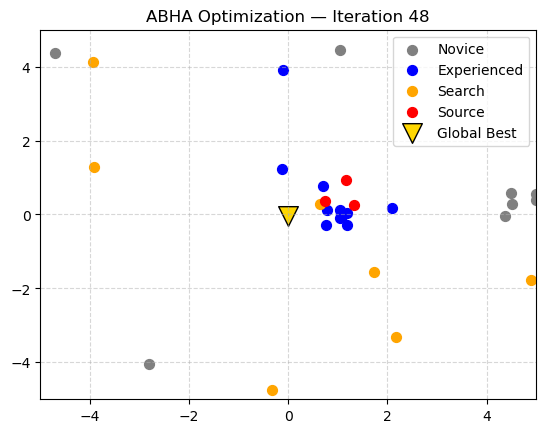

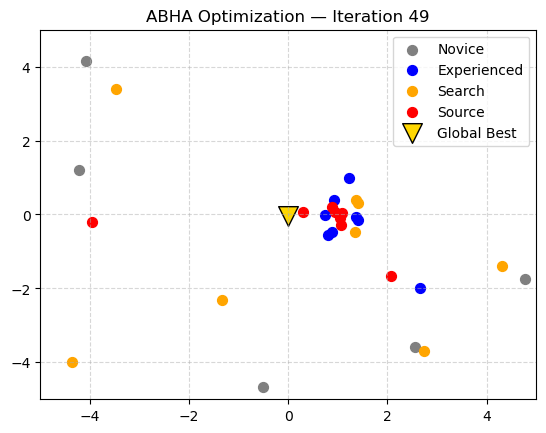

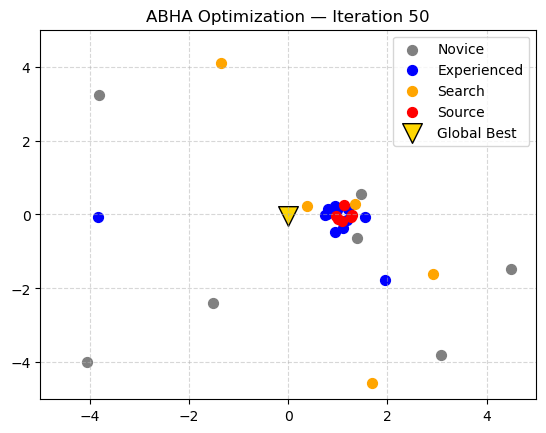

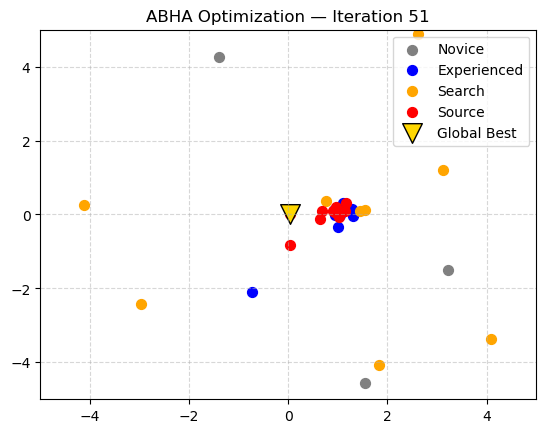

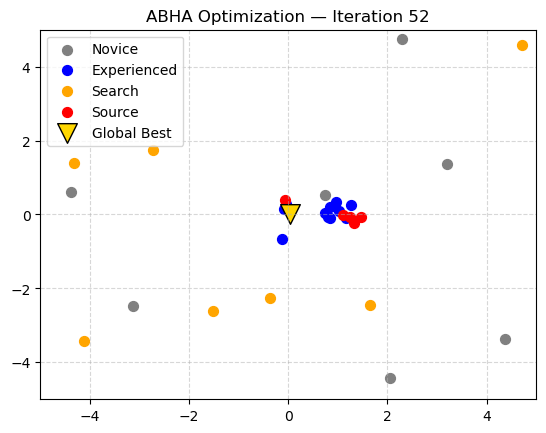

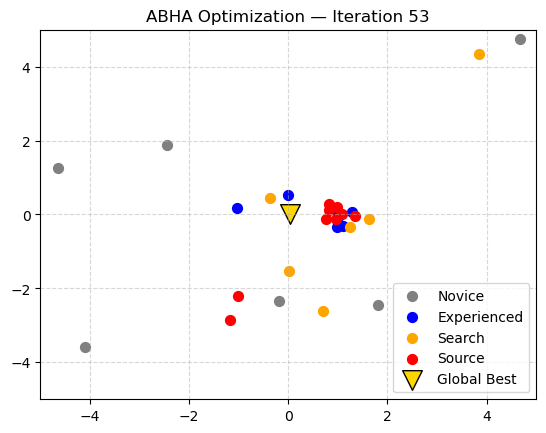

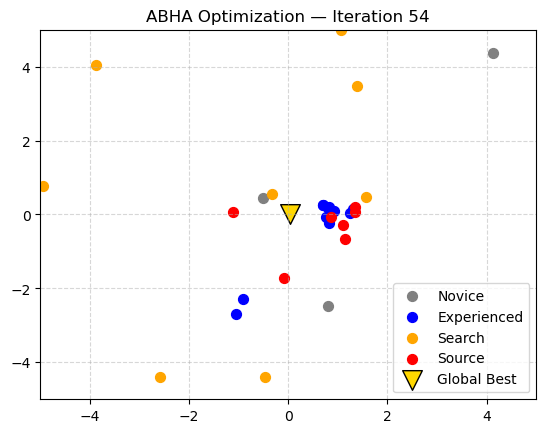

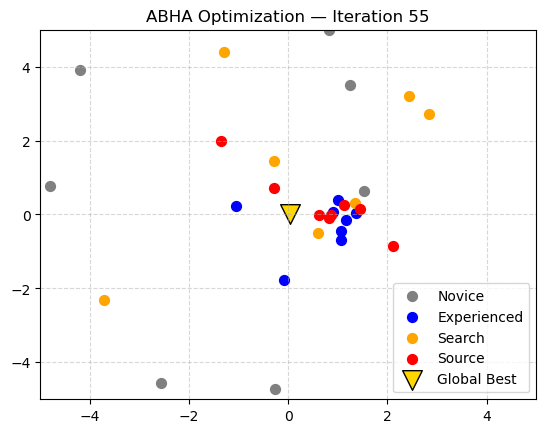

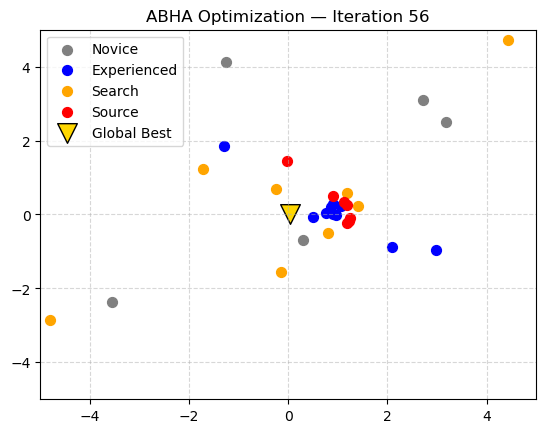

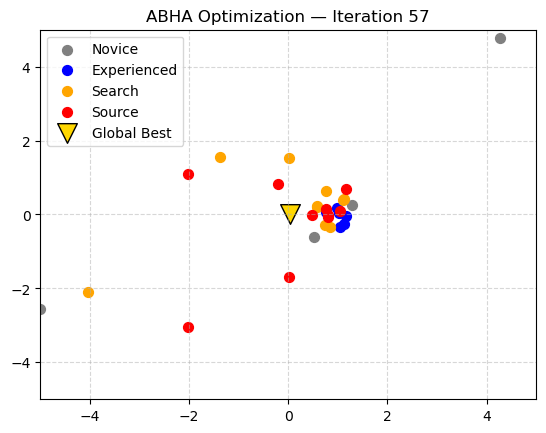

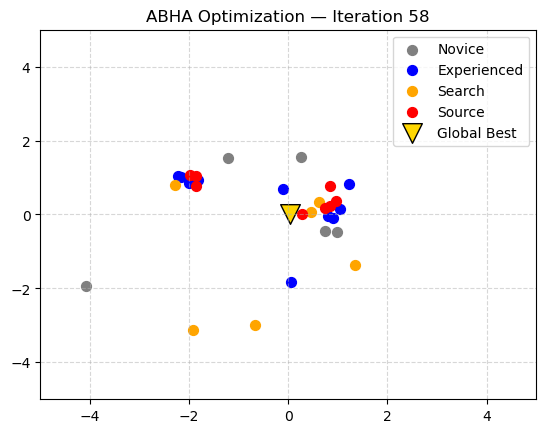

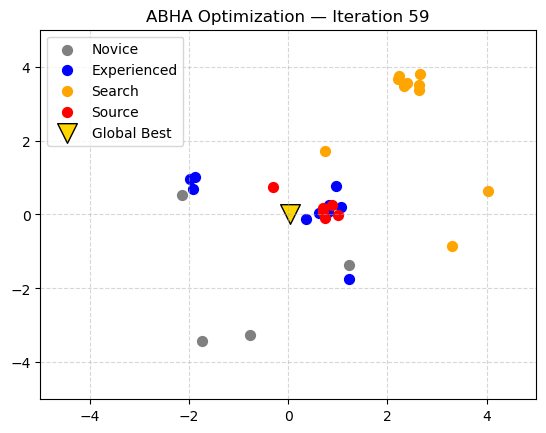

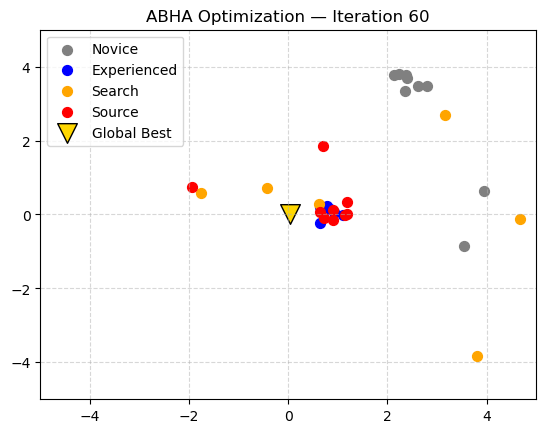

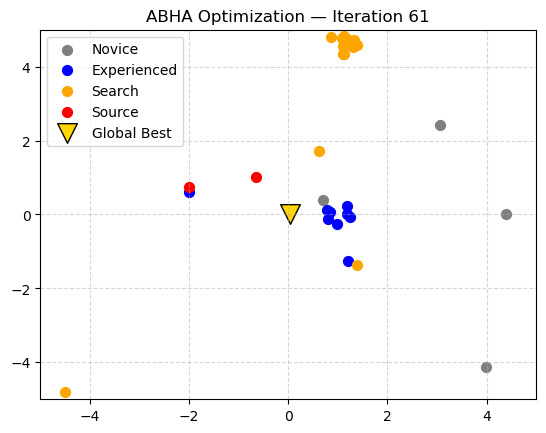

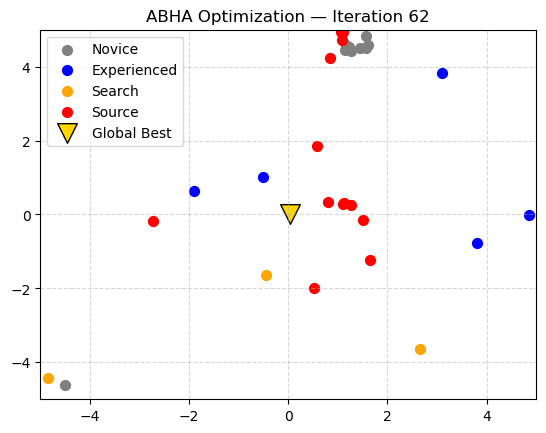

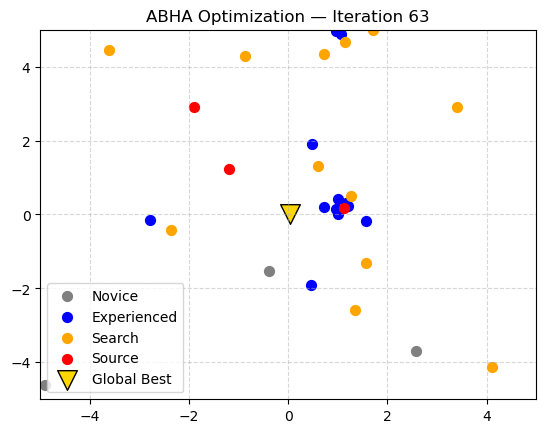

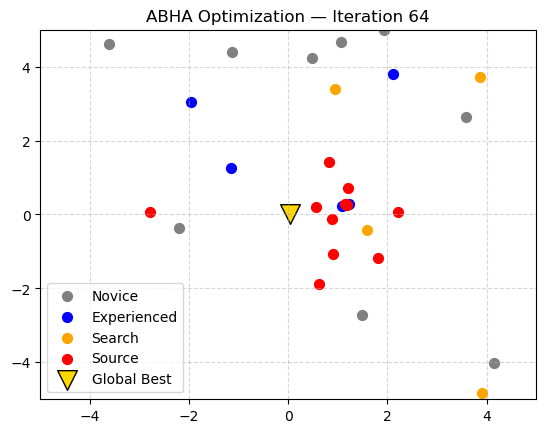

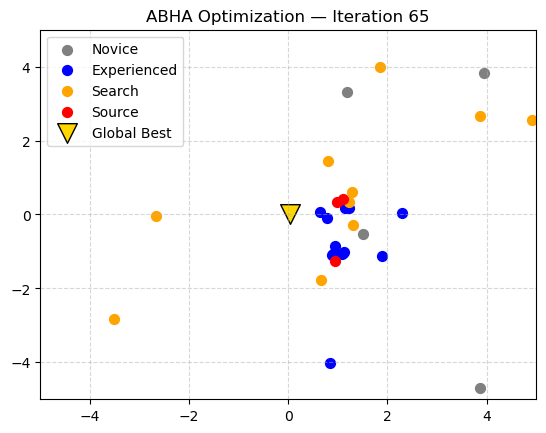

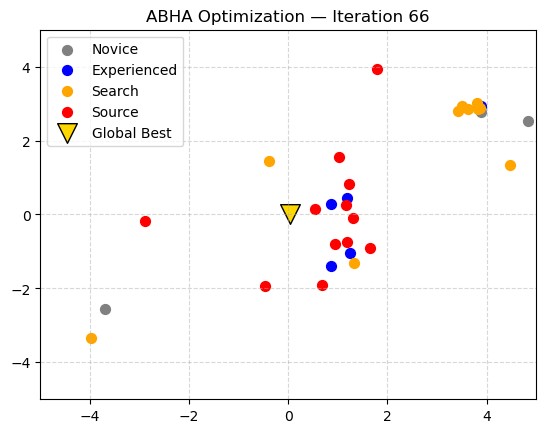

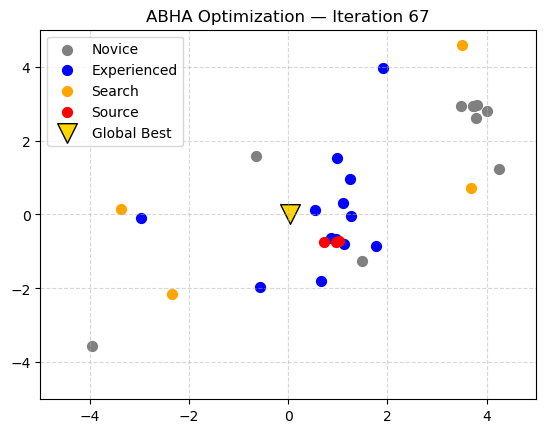

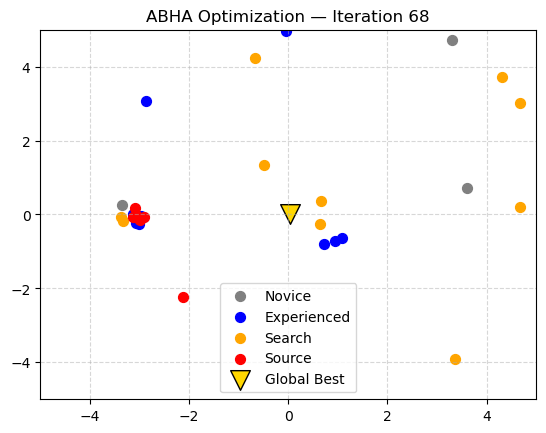

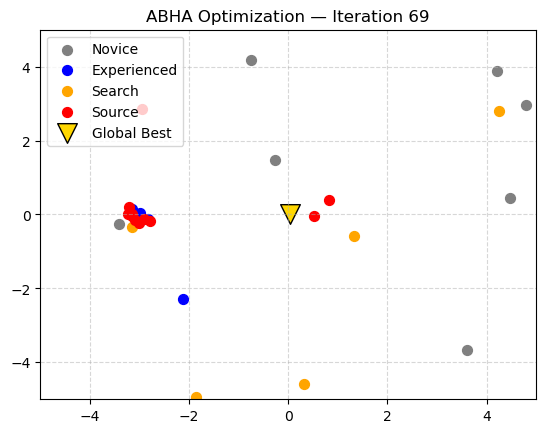

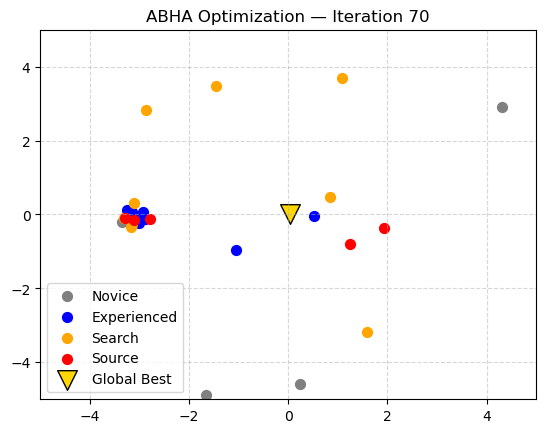

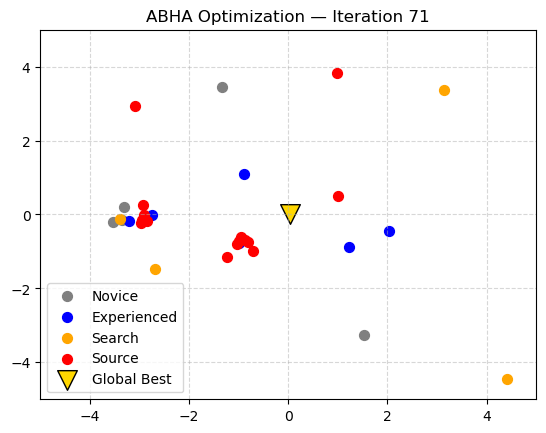

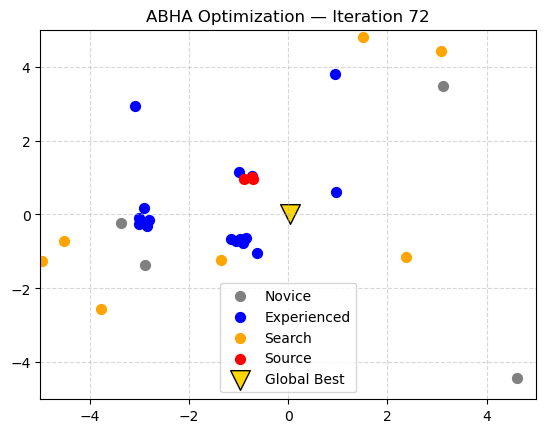

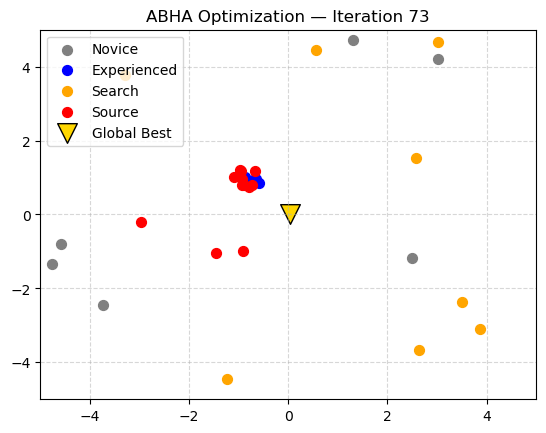

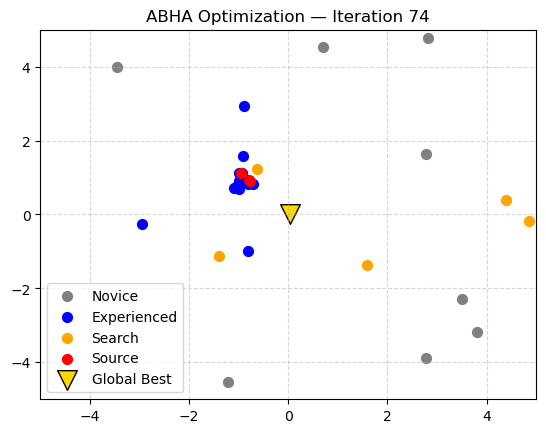

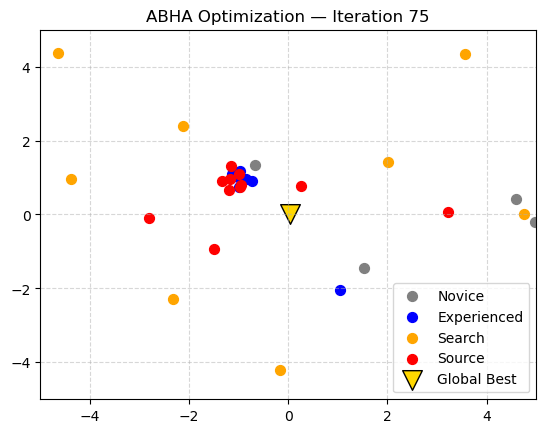

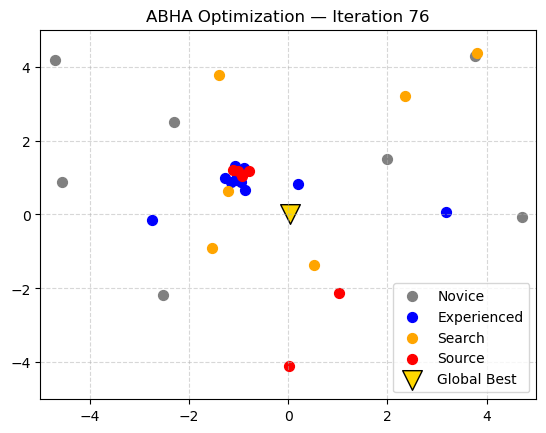

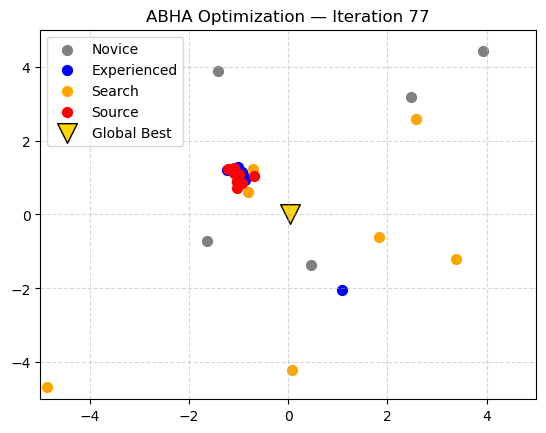

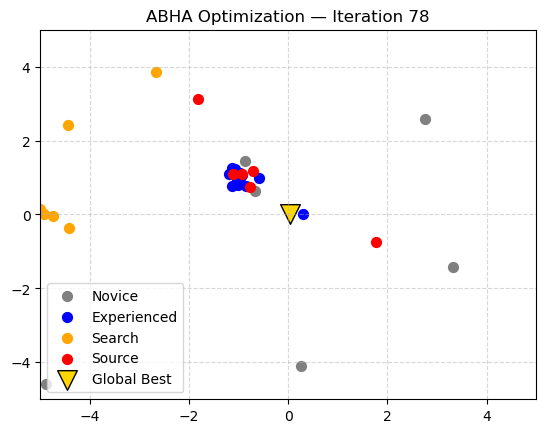

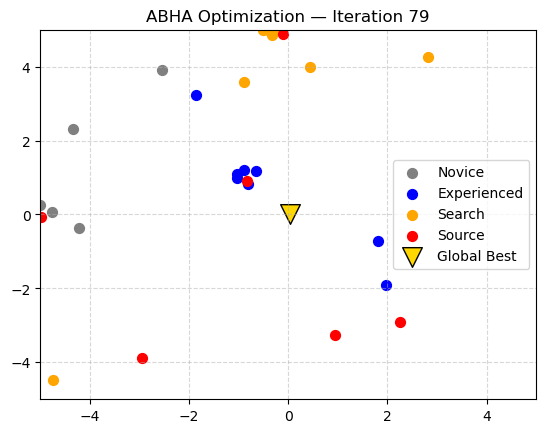

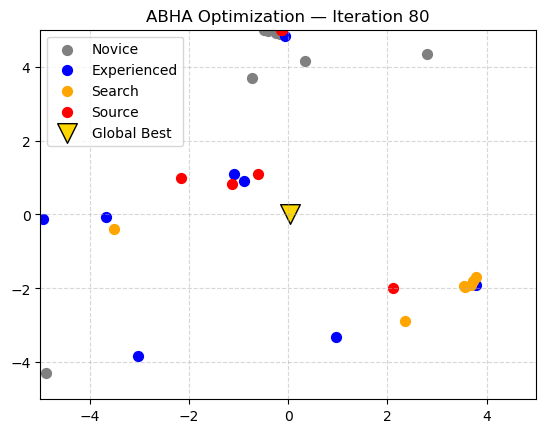

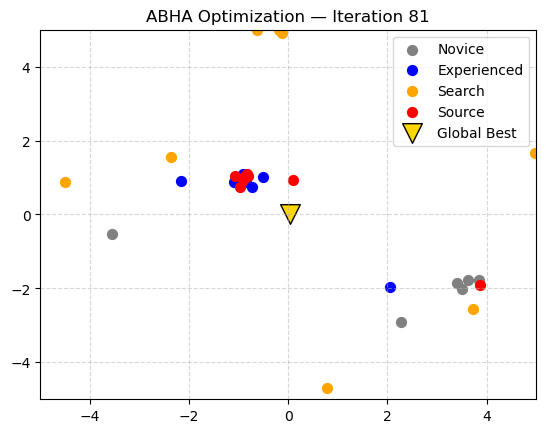

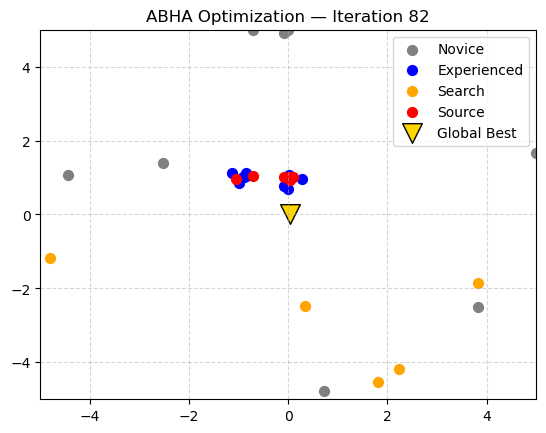

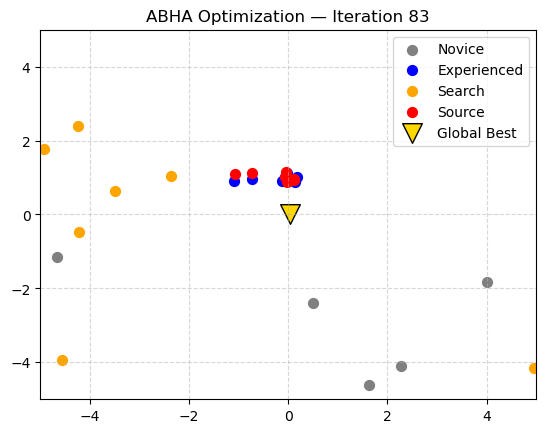

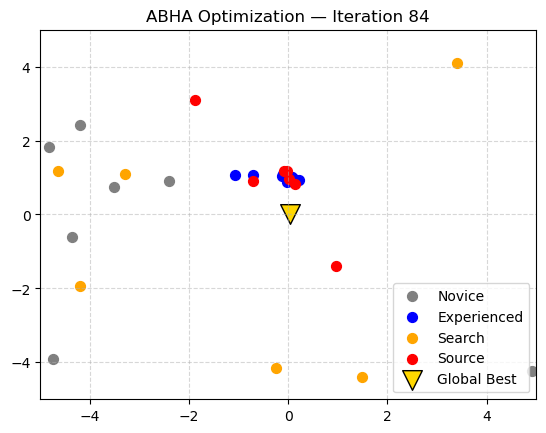

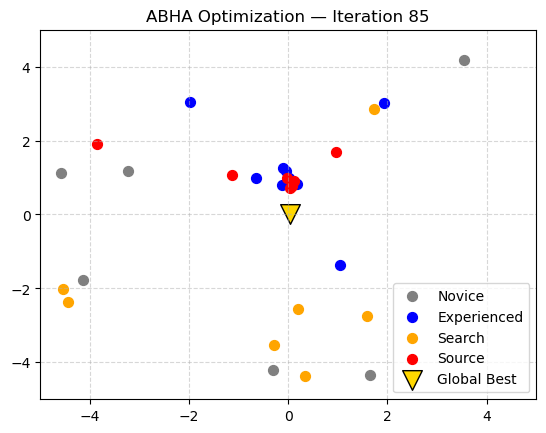

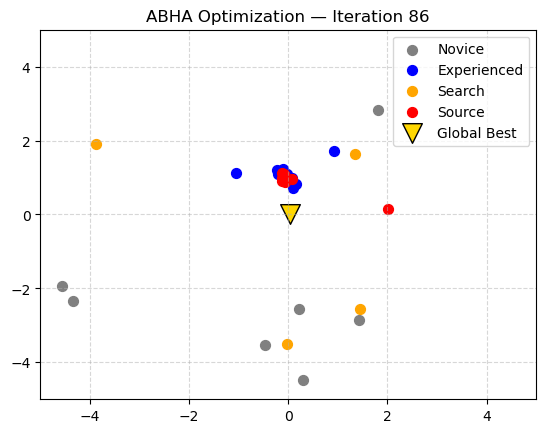

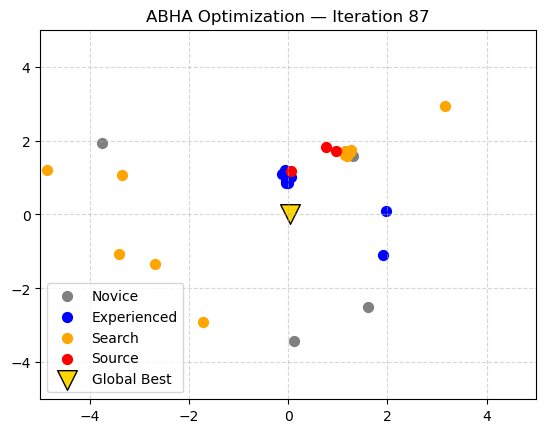

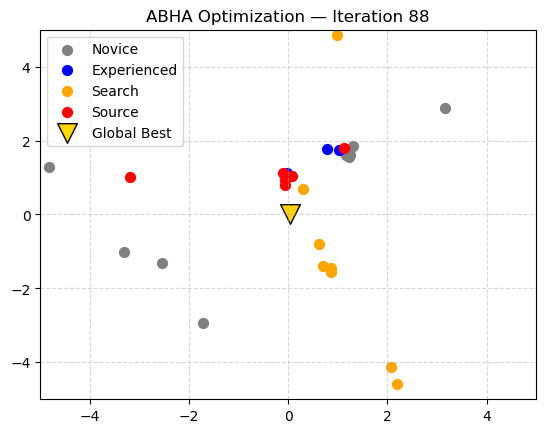

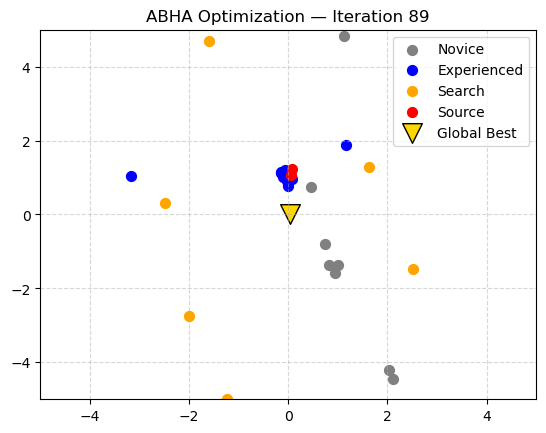

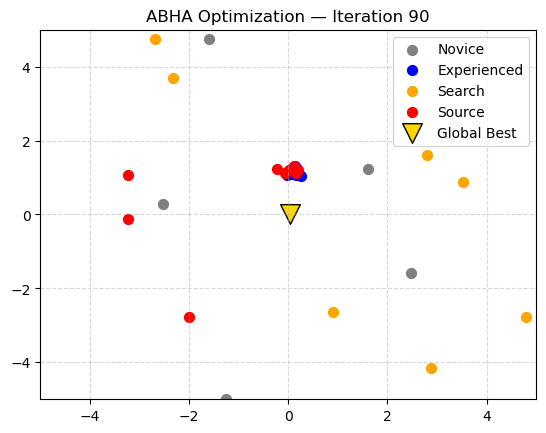

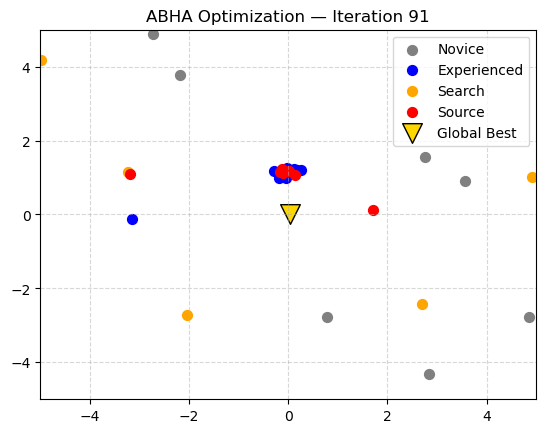

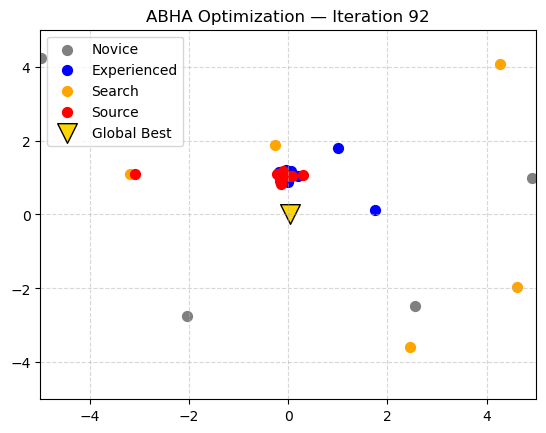

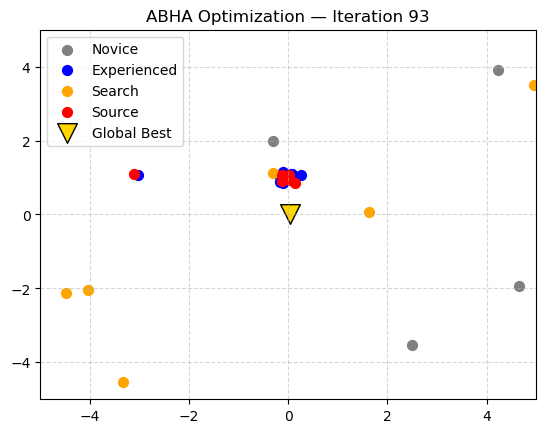

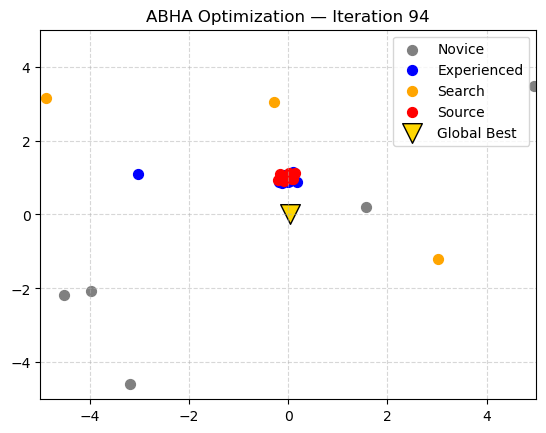

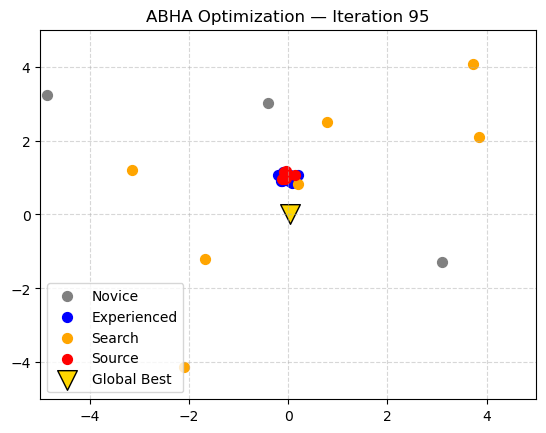

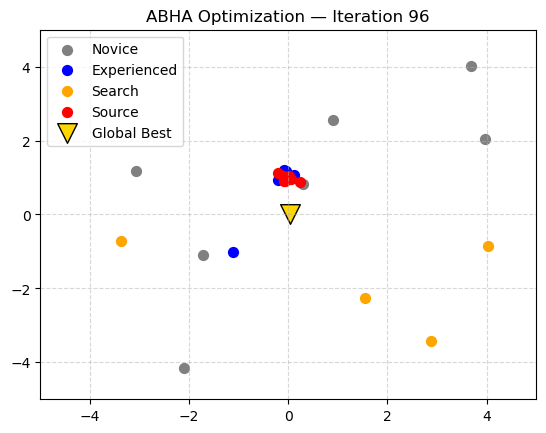

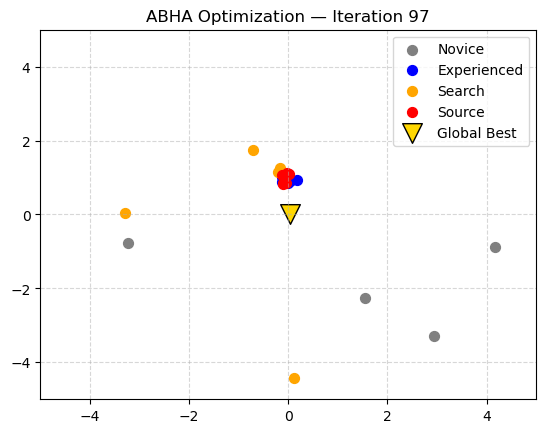

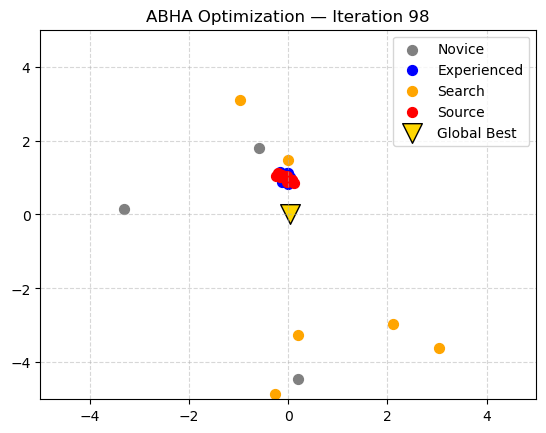

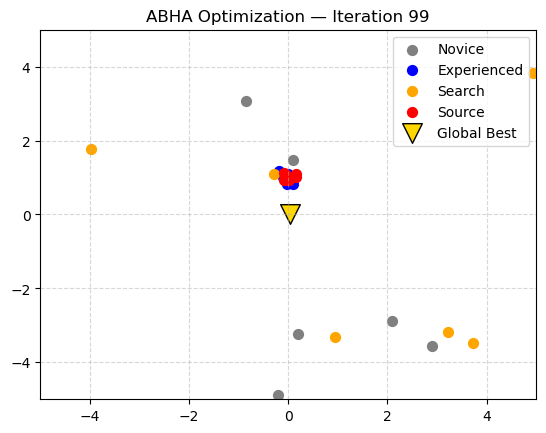

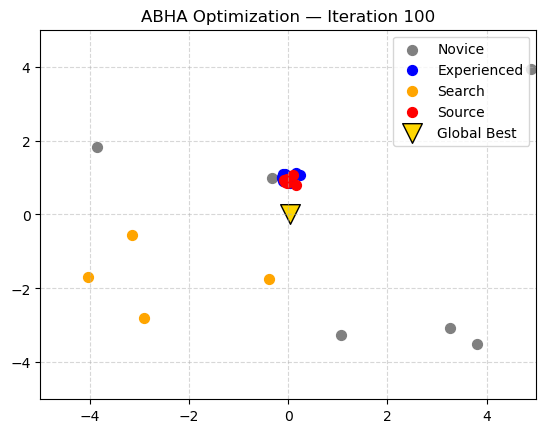

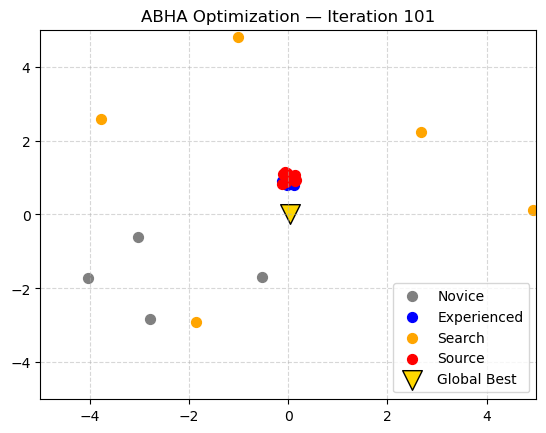

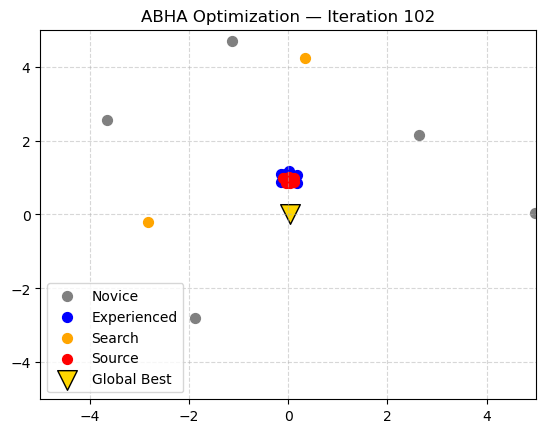

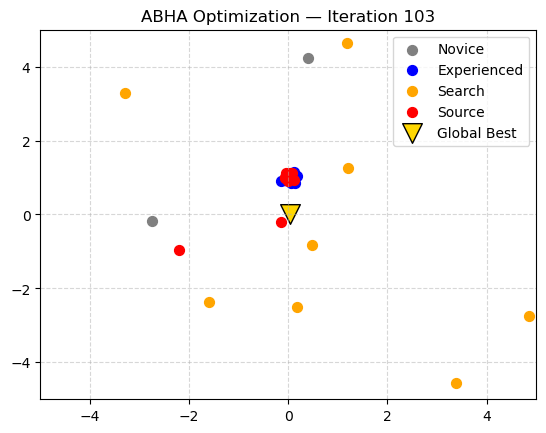

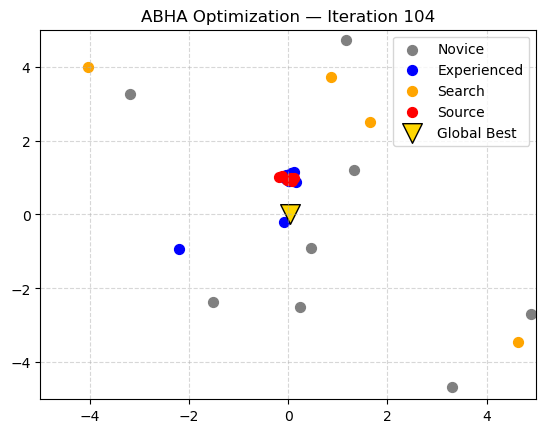

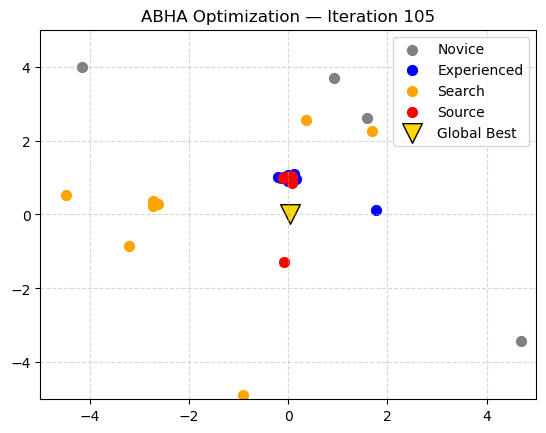

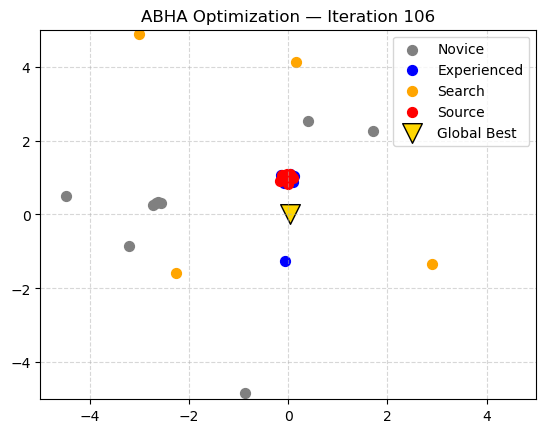

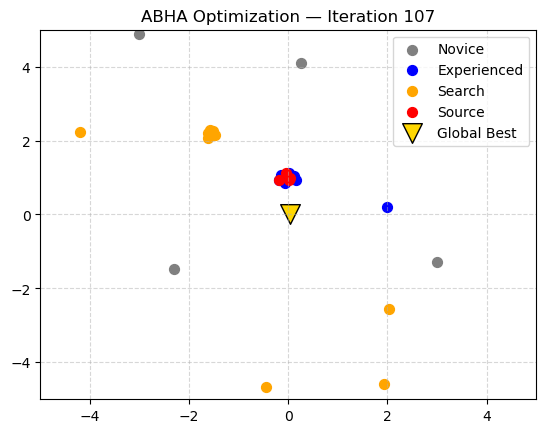

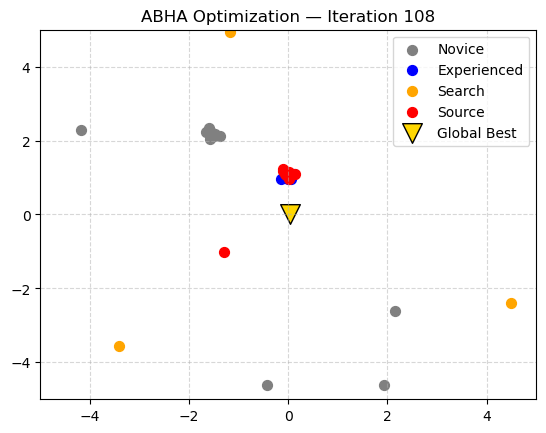

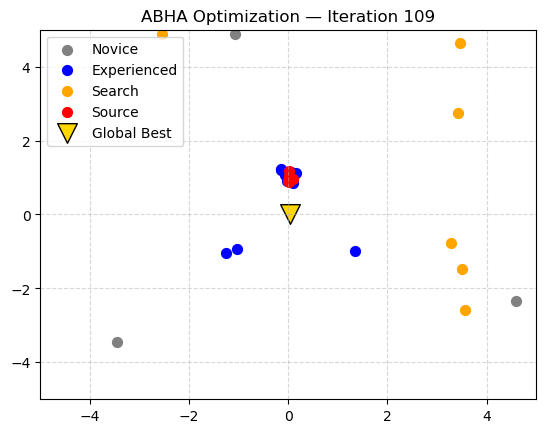

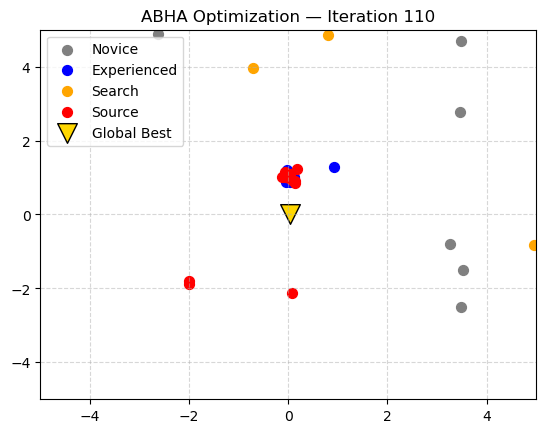

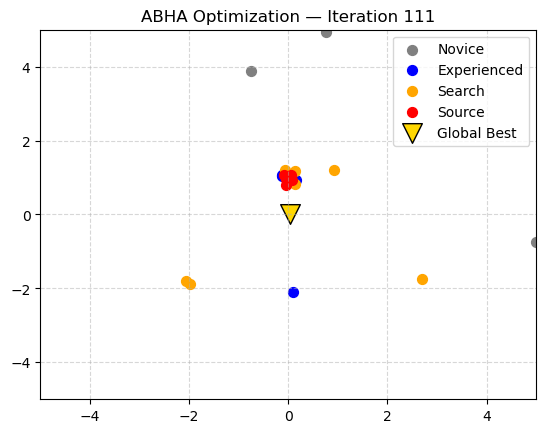

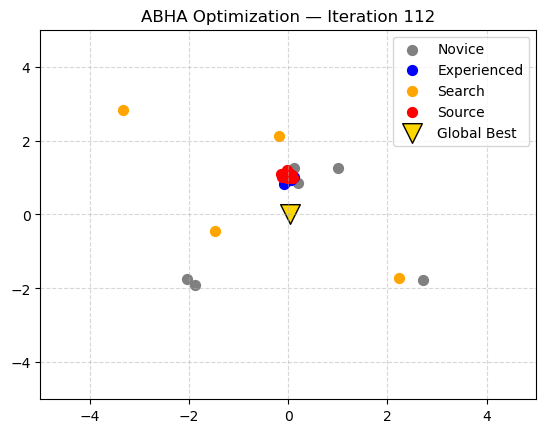

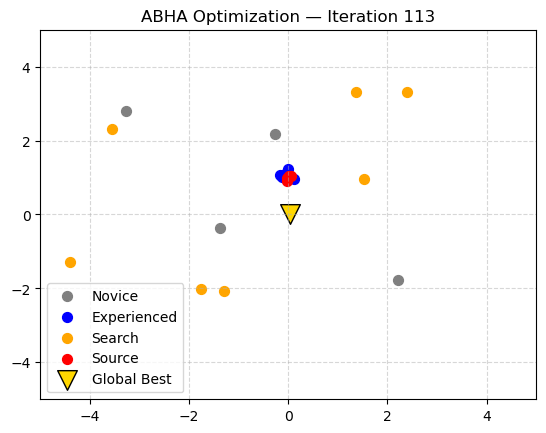

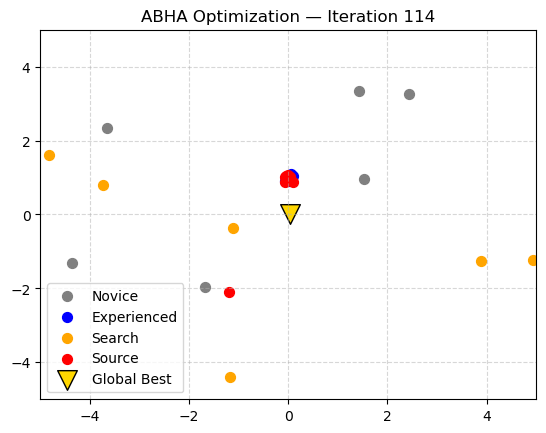

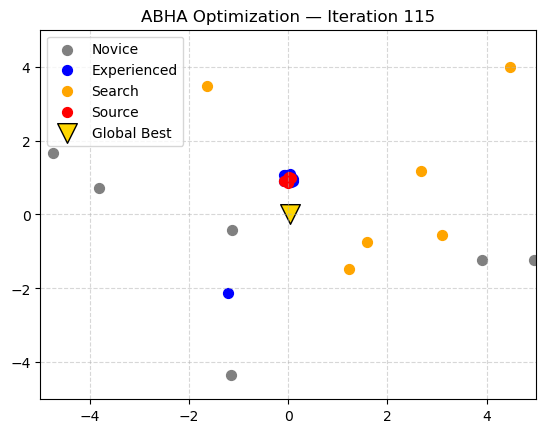

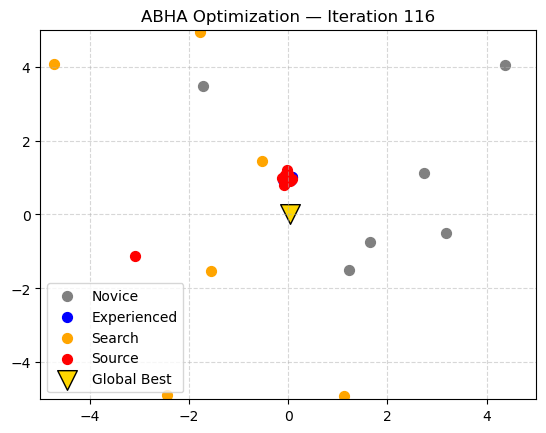

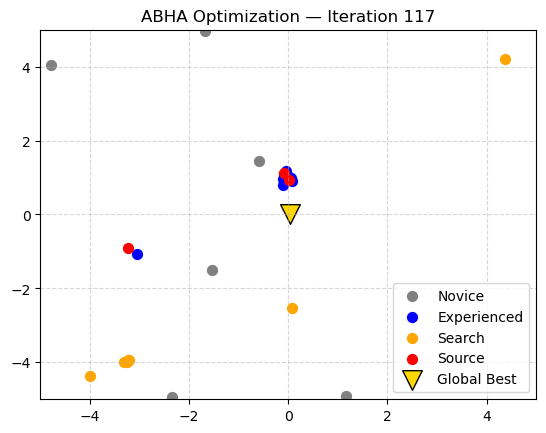

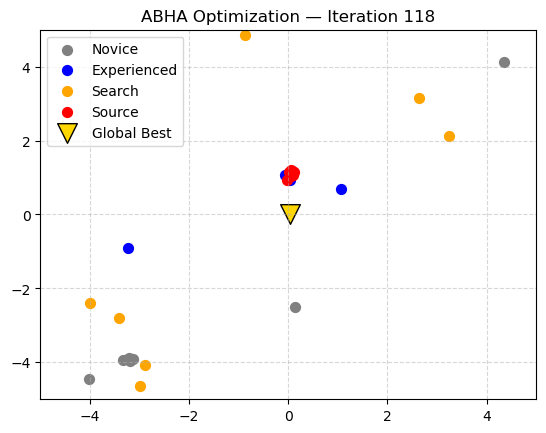

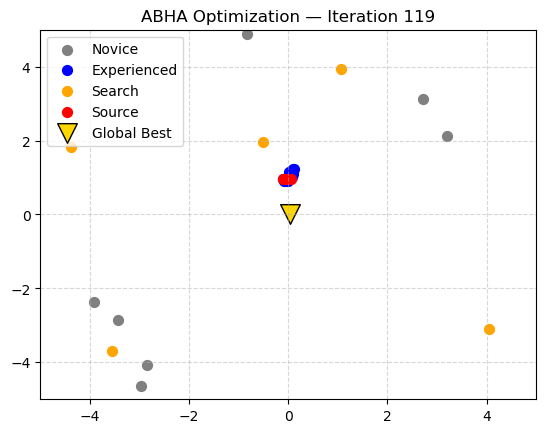

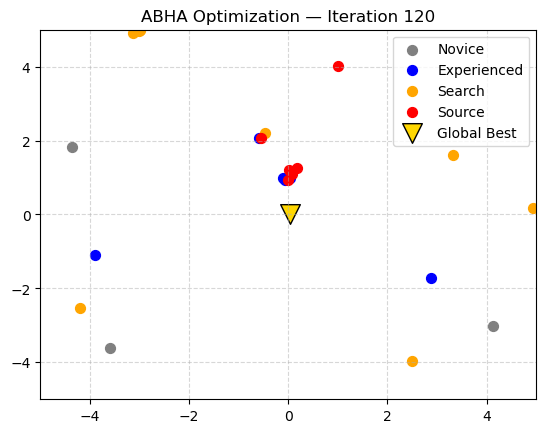

Лучшая позиция: [0.03160167 0.02030937]
Лучшее значение: -0.279200971304018


In [24]:

best_pos, best_val = abha_vis.optimize(visualize=True)
print("Лучшая позиция:", best_pos)
print("Лучшее значение:", best_val)